In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.abundance_classes as ac
import resources.chart_kwargs as ck

import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex


# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

a_fail_rate = 50

# name of the output folder:
name_of_project = 'bassin_report_all'

# set the maps
bassin_map = PILImage.open("resources/maps/survey_locations_all.jpeg")

# define the feature level and components
comps = ['linth', 'rhone', 'aare', 'ticino',]

comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", 'aare':"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}

# these are default
top_name = ["All survey areas"]

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)
        
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y='p/100m', ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr = stats.spearmanr(data[n], data['p/100m']).correlation
    a_p = stats.spearmanr(data[n], data['p/100m']).pvalue
    return ax, corr, a_p

dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)


# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

<a id='top'></a>
## Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes (IQAASL)

IQAASL is a project sponsored by the Swiss Federal Office for the Environment to quantify shoreline trash along swiss lakes and rivers. Multiple small scale **litter surveys** are completed at different locations within a designated survey area. For the year 2020/2021 the survey areas were defined by the municipalities that border the Aare, Rhône, Ticino and Linth/Limmat rivers and any lakes or rivers that contribute.

### What is a litter survey?

A litter survey is the **identification and count of all anthropogenic objects found within a delimited area**, in this study all surveys were bordered on one side by water (a river or lake). Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted. 

#### Purpose of the surveys

The survey results help ALL stakeholders identify the items that make up the mass of trash found in the natural environment and where those objects are most likely to be found. The surveys answer the following questions:

*  What items are found?
   * The most abundant objects from the water feature and the survey area sorted by total object count 
*  How much is found ? (total weights and item counts)
   * Total object count, total weight and weight of plastics
*  How often are these items found?
   * How often the most abundant items were identified
*  Where do you find the most?
   * Pieces of trash per meter (pcs/m): the ratio of number of objects found to the length of the shoreline for each survey location

These are the most frequently asked questions and should be considered in the context of mitigation or reduction strategies.

#### Assumptions:

*  The more trash there is on the ground the more a person is likely to find
*  **The survey results represent the minimum amount of trash at that site**
*  For each survey: finding one item does not effect the chance of finding another

#### Purpose of this report

This is a support document and workspace for summarizing the results from the survey period starting 2020-03-01 and ending 2021-05-31. The survey results are reported in pieces of trash per 100 meters, following the guidance in *A European threshold value and assessment method for macro litter on coastlines*.

<a id="toc"></a>
#### Contents of this report

[Scope: description of survey area](#scope)
  * survey locations
  * lakes and rivers
  * municipalities and effected population
  * [Land use profiles](#luse)
  * selection of survey sites
   
[Survey dimensions: locations, aggregated totals](#aggregatedtotals)
  * weights and measures: cumulative
  * weights and measures: cumulative by water feature
  * material type: % of total

[survey totals : p/100m by date](#stotal)
* disrtibution of survey results 
   
[Trash removed: the most common objects](#combinedtopten)
  * the most common objects definition
  * the most abundant objects
  * objects found in at least half the surveys
  * [the most common objects](#themostcommonobjects)
    * median pcs/m
    * monthly median survey results
    * fail rates
    * correlation with land use attributes
  * [sources](#utility)
    * utility as a % of total
    * monthly median survey results

[Annex](#annex)
  * surveyors  
  * survey location coordinates
  * itemized list of objects removed

### More information

For more information about the project visit [project home](https://www.plagespropres.ch/).

If you would like more information about this survey area please contact:

1. Swiss federal office for the environment - Municipal waste section
2. analyst@hammerdirt.ch

### <a id="scope"></a>Scope IQAASL
<!-- 
The Aare source is the Aare Glaciers in the Bernese Alps of south-central Switzerland. The Aare is the longest river entirely within Switzerland with a length of 295 km and drainage area of 17,779 km2. Following the Aare Gorge, the river expands into the glacial Lake Brienz. The Aare is canalized at Interlaken before entering Lake Thun and exiting through the city of Thun. The river then flows northwest surrounding the old city center of Bern on three sides. Continuing west to Lake Wohlen Reservoir it turns north to Aarberg and is diverted west into Lake Biel by the Hagneck Canal, one of a series of major water corrections made in the 19th and 20th centuries connecting Neuchatel, Biel and Morat lakes through canalization. From the upper end of Lake Biel, at Nidau, the river exits through the Nidau-Büren Canal/Aare Canal.

The Limmat and Reuss rivers, two major tributaries converge into the Aare at the Limmatspitz between the cities of Brugg and Untersiggenthal in Canton Aargau. The Aare river ends in the north-western region of Koblenz, Switzerland where it joins the Rhine river which eventually terminates in the North Sea. -->

#### Survey locations and municipalities


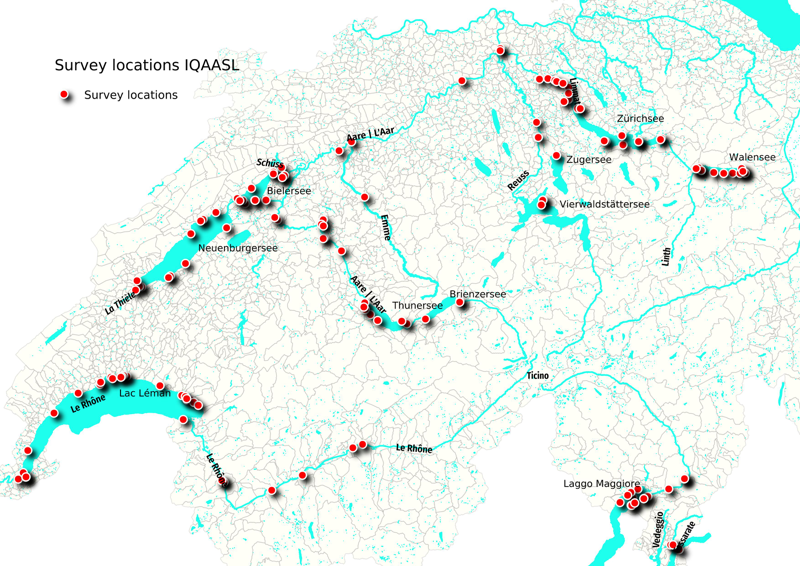

In [2]:
output = io.BytesIO()
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

In [3]:
a_data = survey_data.copy()
a_dated = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)].copy()

# format columns and slice by date
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

# combine lugano and maggiore
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000
a_data['p/100m'] = (a_data.pcs_m *100).astype('int')

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

the_plast_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
a_data = sut.replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# code and material totals
material_totals = a_data.groupby('material').quantity.sum()
code_totals = a_data.groupby(['code'], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})

# percent of total
code_totals["% of total"] = ((code_totals.quantity/code_totals.quantity.sum())*100).round(2)
code_totals["fail"] = code_totals.code.map(lambda x: a_data[(a_data.code == x) & (a_data.quantity > 0)].loc_date.nunique())
code_totals["fail rate"] = ((code_totals.fail/a_data.loc_date.nunique())*100).astype('int')
code_totals.set_index('code', inplace=True)
code_totals['material'] = code_totals.index.map(lambda x: code_material_map[x])
code_totals['item'] = code_totals.index.map(lambda x: code_description_map[x])

# survey totals
dt_all = a_data.groupby(['loc_date','location','river_bassin', 'water_name_slug','city','date'], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})

# if needed make a map of the medain survey result for each location
# lat_lon_map = dfBeaches[['latitude', 'longitude']]

# this will produce a points layer on QGIS with the median p/100m and the total quantity:
# median_survey_result_all_locations = dt_all.groupby(['location', 'river_bassin','water_name_slug'], as_index=False).agg({"p/100m":"median", "loc_date":"nunique"})
# # median_survey_result_all_locations['p/100m'] = (median_survey_result_all_locations.p/100m * 100).astype('int')
# median_survey_result_all_locations['latitude'] = median_survey_result_all_locations.location.map(lambda x: lat_lon_map.loc[x].latitude)
# median_survey_result_all_locations['longitude'] = median_survey_result_all_locations.location.map(lambda x: lat_lon_map.loc[x].longitude)

In [4]:
fd = a_data.copy()
# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][['city','population']].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index('city', drop=True, inplace=True)

# survey_totals river bassin
fd_dt=dt_all.copy()

# map survey total quantity to loc_date
fd_dq = fd_dt[['loc_date', 'quantity']].set_index('loc_date')

# material totals:
fd_mat_t = code_totals[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()

# summary statistics:
fd_n_samps = len(fd_dt)
fd_n_obj = fd.quantity.sum()
fd_n_locs = fd.location.nunique()
fd_n_munis = len(fd_pop_map.index)
fd_effected_population = fd_pop_map.sum()

In [5]:
obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(int(fd_effected_population[0]))

In [6]:
date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results with a combined population of approximately {pop_string}."
md(F"{date_quantity_context} {geo_context } {admin_context}")

For the period between 2020-03 and 2021-05, 54,713 objects were removed and identified in the course of 385 surveys. Those surveys were conducted at 143 different locations. There are 77 different municipalities represented in these results with a combined population of approximately 1,735,991.

In [7]:
fd_locs = fd.location.unique()
fd_samps = fd.loc_date.unique()

# gather the dimensional data for the time frame from dfDims
fd_dims= dfDims[(dfDims.location.isin(fd_locs))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

m_ap_to_survey_area = fd[['location', 'river_bassin']].drop_duplicates().to_dict(orient='records')
a_new_map = {x['location']:x['river_bassin'] for x in m_ap_to_survey_area}

fd_dims['survey area'] = fd_dims.location.map(lambda x: ut.use_this_key(x, a_new_map))

In [8]:
st_map = fd_dims[['loc_date', 'length', 'area']].to_dict(orient='records')
amap = {x['loc_date']:{'length':x['length'], 'area':x['area']}for x in st_map}
trans = {x:F"{x}"for x in fd.loc_date.unique()}

def this_map(x,amap,trans, var='length'):
    try:
        data = amap[trans[x]][var]
    except:
        data = 0
    return data
    
    
fd['length'] = fd.loc_date.map(lambda x:  this_map(x,amap,trans, var='length'))
fd['area'] = fd.loc_date.map(lambda x:  this_map(x,amap,trans, var='area'))
fd['water'] = fd.location.map(lambda x: dfBeaches['water'][x])

make_lengths = fd.loc[fd.location.isin(['baby-plage-geneva','quai-maria-belgia'])].groupby('location').agg({'length':'mean', 'area':'mean'})
fd.loc[fd.loc_date == ('baby-plage-geneva', '2021-04-14'), 'length'] = 84
fd.loc[fd.loc_date == ('baby-plage-geneva', '2021-04-14'), 'area'] = 355
fd.loc[fd.loc_date.isin([('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31')]), 'length'] = 34
fd.loc[fd.loc_date.isin([('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31')]), 'area'] = 145

In [9]:
# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# key the quantity from the survey totals to the dimensional data
try_this = {x:fd_dt[fd_dt.loc_date == x]['quantity'].to_numpy()[0] for x in fd_dt.loc_date.unique()}

# map quantity per survey to the dims data
fd_dims['quantity'] = fd_dims.loc_date.map(lambda x: ut.use_this_key(x, try_this))

# keep the dims that did not get tagged with a qty
no_qty = fd_dims[fd_dims.quantity == 'bad key']

# drop the dims that did not match
som_dims = fd_dims[fd_dims.quantity != 'bad key'].copy()
som_dims['water_name_slug'] = som_dims.location.map(lambda x: location_wname_key.loc[x])

# identify the surveys with no matching dimensional data
no_matching_dim_records = [x for x in list(fd_samps) if x not in list(fd_dims.loc_date.unique())]

lakes = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['water_name'].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'r')]['water_name'].unique()

In [10]:
munis_joined = ', '.join(sorted(fd_pop_map.index))

muni_string = F"""**The municipalities in this report:**\n\n{munis_joined}
"""
md(muni_string)

**The municipalities in this report:**

Aarau, Allaman, Ascona, Beatenberg, Bellinzona, Bern, Biel/Bienne, Boudry, Bourg-en-Lavaux, Brienz (BE), Brissago, Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Dietikon, Erlach, Estavayer, Freienbach, Gals, Gambarogno, Gebenstorf, Genève, Gland, Glarus Nord, Grandson, Hauterive (NE), Hünenberg, Kallnach, Köniz, Küsnacht (ZH), La Tour-de-Peilz, Lausanne, Lavey-Morcles, Le Landeron, Leuk, Ligerz, Locarno, Lugano, Luterbach, Lüscherz, Merenschwand, Minusio, Montreux, Neuchâtel, Nidau, Port, Préverenges, Quarten, Rapperswil-Jona, Richterswil, Riddes, Rubigen, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Schmerikon, Sion, Solothurn, Spiez, Stäfa, Thun, Tolochenaz, Unterengstringen, Unterseen, Versoix, Vevey, Vinelz, Walenstadt, Walperswil, Weesen, Weggis, Yverdon-les-Bains, Zug, Zürich


In [11]:
lakes_joined = ', '.join(sorted(lakes))

lake_string = F"""**The lakes in this report:**\n\n{lakes_joined}
"""
md(lake_string)

**The lakes in this report:**

Bielersee, Brienzersee, Lac Léman, Lago Maggiore, Lago di Lugano, Neuenburgersee, Quatre Cantons, Thunersee, Walensee, Zugersee, Zurichsee


In [12]:
rivers_joined = ', '.join(sorted(rivers))

river_string = F"""**The rivers in this report:**\n\n{rivers_joined}
"""
md(river_string)

**The rivers in this report:**

Aare, Aare|Nidau-Büren-Kanal, Cassarate, Dorfbach, Emme, Escherkanal, Jona, La Thièle, Limmat, Linthkanal, Maggia, Reuss, Rhône, Schüss, Seez, Sihl, Ticino


In [13]:
# 90-120 minutes covers some of the travel, equipment preparation and maintenance and incidental time on location:
som_dims['total_time'] = ((som_dims.time_minutes+90)/60).round(2)

# rename the columns for display and export:
som_dims.rename(columns=sut.new_cols, inplace=True)

dims_summary_stats = som_dims.groupby('survey area').agg(sut.agg_this)

# convert the plastic weights to kilos
dims_summary_stats['plastic > 5mm weight'] = dims_summary_stats['plastic > 5mm weight']/1000
dims_summary_stats['plastic < 5mm weight'] = dims_summary_stats['plastic < 5mm weight']/1000

# labor hours = (staff+help/number of samples)*time_to_survey
dims_summary_stats['labor hours'] = ((dims_summary_stats.staff + dims_summary_stats.help)/dims_summary_stats["# samples"])*dims_summary_stats['time to survey']
dims_summary_stats['labor hours'] = dims_summary_stats.astype('int')

# get the quantity found feature
dims_summary_stats['pieces of trash'] = dims_summary_stats.index.map(lambda x: fd.loc[fd.river_bassin == x].quantity.sum())

[Menu](#toc)<a id="luse"></a>
### Land use profile of the survey locations

Land use is a method to differentiate survey sites in other ways besides the amount of trash collected. The land use mix is a unique representation of the type and amplititude of econmic activity around the survey location. The key indicators from the survey results are compared against the land use rates for a radius of 1500m from the survey location.

#### Calculating land use

The Office fédéral de la statistique provides the 'Statistique de superficie', a grid of points 100m x 100m that covers Switzerland. Each point is assigned one of 27 different land use categories. This grid, as well as the relevant map layers from swissTLMRegio are the basis of determining these values. River discharge points and the length of streets is extracted from the relevant map layer using QGIS.

The land use mix within 1500 meters around each survey location was evaluated for the following criteria:

1. % of surface area attributed to buildings
2. % of surface area left to woods
3. % of surface area attributed to outdoor activities
4. % of surface area attributed to aggriculture
5. length in meters of all roadways 
6. number of river discharge intersections

The data for the first four attributes was taken from the Statistique suisse de superficie using the data for the survey 2013/18 (AS1827). The points representing the different land use attributes were added together and divided by the total number of points within the 1500m buffer **not attributed to a water feature**. The street length was calculated using the streets layer from swissTLMRegio.

The number of river discharge intersections is the number of streams/rivers/canals that empty into the lake of interest within 1500m of the survey location. This information is obtained by intersecting the streams layer with the lakes layer from swissTLMRegio. See the section on calculating land use for more details.

The distribution of the number of surveys completed at the different land use rates. The land use is reported as the percent of total area attributed to each land use category within a 1500m  radius of the survey location. Street rank is the ordinal ranking of the length of all streets/pathways within the 1500m buffer.  Intersects is also an ordinal ranking of the number of rivers/canals that intersect a lake within 1500m of the survey location.

In [14]:
# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,'% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods','population','river_bassin','water_name_slug','streets km', 'intersects', 'groupname','code']
lakes_s = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')&(dfBeaches.water_name_slug != 'walensee')]['water_name_slug'].unique()

fd.rename(columns={'str_rank':'street rank'}, inplace=True)
dfdt = fd.groupby(use_these_cols[:-2], as_index=False).agg({'p/100m':'sum'})

#### Survey areas: distribution of surveys by measured land use attributes

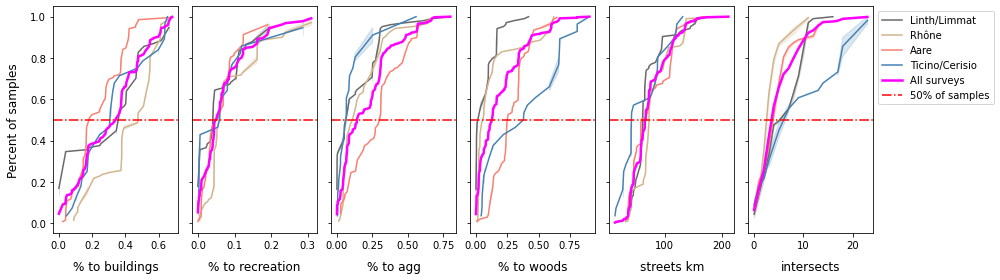

In [15]:
bassin_pallette = {'rhone':'dimgray', 'aare':'salmon', 'linth':'tan', 'ticino':'steelblue', 'reuss':'purple'}
comp_palette = {"Linth/Limmat":"dimgray", "Rhône":"tan", "Aare":"salmon", "Ticino/Cerisio":"steelblue", "Reuss":"purple"}
fig, axs = plt.subplots(1,len(luse_exp), figsize=(14,4), sharey=True)
ecdfs = {x:{} for x in comps}
ecdfs.update({"All surveys":{}})
for i, n in enumerate(luse_exp):
    for element in comps:
        ax=axs[i]
        the_data = ECDF(dfdt[dfdt.river_bassin == element][n].values)
        ecdfs[element].update({n:the_data})
        
        x, y = the_data.x, the_data.y   

        sns.lineplot(x=x, y=y, ax=ax, label=comp_labels[element], color=comp_palette[comp_labels[element]])
    
    a_all_surveys =  ECDF(dfdt[n].values)
    ecdfs["All surveys"].update({n:a_all_surveys})
    
    x, y = a_all_surveys.x, a_all_surveys.y
    sns.lineplot(x=x, y=y, ax=ax, label="All surveys", color="magenta", linewidth=2.5)
    ax.axhline(y=.5, linestyle="-.", color="red", label="50% of samples")
    
    if i == 0:
        ax.set_ylabel("Percent of samples", **ck.xlab_k)
    else:
        pass   
      
    ax.set_xlabel(n, **ck.xlab_k)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
plt.legend(handles, labels, bbox_to_anchor=(1,1))       
plt.tight_layout()
plt.show()  

In [16]:
# # # 50% to buildings
# print(np.median(ecdfs['rhone']["% to buildings"].x))
# print(np.median(ecdfs['aare']["% to buildings"].x))
# print(np.median(ecdfs['ticino']["% to buildings"].x))
# print(np.median(ecdfs['linth']["% to buildings"].x))
# print(np.median(ecdfs['All surveys']["% to buildings"].x))

# print("\nagg\n")
# # 50% to agg
# print(np.median(ecdfs['rhone']["% to agg"].x))
# print(np.median(ecdfs['aare']["% to agg"].x))
# print(np.median(ecdfs['ticino']["% to agg"].x))
# print(np.median(ecdfs['linth']["% to agg"].x))
# print(np.median(ecdfs['All surveys']["% to agg"].x))
# print("\nWoods\n")
# # 50% to woods
# print(np.median(ecdfs['rhone']["% to woods"].x))
# print(np.median(ecdfs['aare']["% to woods"].x))
# print(np.median(ecdfs['ticino']["% to woods"].x))
# print(np.median(ecdfs['linth']["% to woods"].x))
# print(np.median(ecdfs['All surveys']["% to woods"].x))

# print("\nstreets\n")
# # 50% to woods
# print(np.median(ecdfs['rhone']["streets km"].x))
# print(np.median(ecdfs['aare']["streets km"].x))
# print(np.median(ecdfs['ticino']["streets km"].x))
# print(np.median(ecdfs['linth']["streets km"].x))
# print(np.median(ecdfs['All surveys']["streets km"].x))

The survey locations in the Rhône survey area (RSA) had the greatest median amount of land attributed to buildings, 47%, the Aare survey area (ASA) had the lowest at 13%. The median value of all surveys is 34% of land around the survey area attributed to buildings. The inverse is true for the median values of land attributed to aggriclulture or woods, the median amount of land attributed to woods or aggriculture in the RSA was 5% and 11% versus 24% and 30% for the ASA. The median amount of land attributed for all surveys to woods was 13% and for aggriculture it was 14%.

Despite differences in land use, the road network and the allocation of land to recreational activities is similar accross the different survey areas.



#### Choosing survey sites

The survey locations were chosen based on the following criteria:

1. Data from previous surveys (SLR, MCBP)
2. Year round safe access
3. Within 30 minutes walking distance from nearest public transport

#### Distribution of survey results by survey length

median survey length = 45, median p/100m = 166

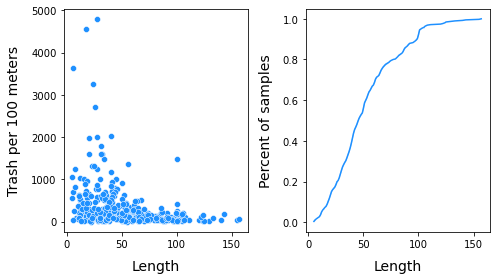

In [17]:
fd['p/m²'] = fd.quantity/fd.area
fig, ax = plt.subplots(1,2, figsize=(7,4))

the_data = fd.groupby(['loc_date', 'length'], as_index=False)['p/100m'].sum()
lcdf = ECDF(the_data.length.values)

sns.scatterplot(data=the_data , x='length', y='p/100m',  color='dodgerblue', ax=ax[0])
sns.lineplot(data=lcdf, x=lcdf.x, y=lcdf.y, color='dodgerblue', ax=ax[1])
ax[0].set_ylabel("Trash per 100 meters", **ck.xlab_k14)
ax[1].set_ylabel("Percent of samples", **ck.xlab_k14)

ax[0].set_xlabel("Length", **ck.xlab_k14)
ax[1].set_xlabel("Length", **ck.xlab_k14)

plt.tight_layout()
plt.show()

In [18]:
# print(np.median(lcdf.x))
# median length 45

#### Distribution of survey results by survey area

median m² per survey = 179, median p/m² = 0.54

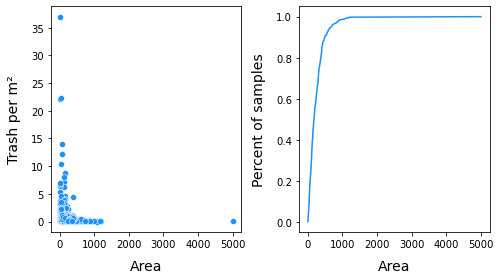

In [19]:
fd['p/m²'] = fd.quantity/fd.area
fig, ax = plt.subplots(1,2, figsize=(7,4))

the_data = fd.groupby(['loc_date', 'area'], as_index=False)['p/m²'].sum()
lcdf = ECDF(the_data.area.values)

sns.scatterplot(data=the_data , x='area', y='p/m²',  color='dodgerblue', ax=ax[0])
sns.lineplot(data=lcdf, x=lcdf.x, y=lcdf.y, color='dodgerblue', ax=ax[1])
ax[0].set_ylabel("Trash per m²", **ck.xlab_k14)
ax[1].set_ylabel("Percent of samples", **ck.xlab_k14)

ax[0].set_xlabel("Area", **ck.xlab_k14)
ax[1].set_xlabel("Area", **ck.xlab_k14)

plt.tight_layout()
plt.show()

In [20]:
# print(np.median(lcdf.x))
# print(the_data["p/m²"].median())

# median m² 179
# median p/m² = 0.54

In [21]:
site_string = F"""**The survey locations represent the land use conditions accesible to approximateley {pop_string} people** and add to the results from previous projects that used a similar protocol. For more information see the document *Survey site selection and criteria*.
"""
md(site_string)

**The survey locations represent the land use conditions accesible to approximateley 1,735,991 people** and add to the results from previous projects that used a similar protocol. For more information see the document *Survey site selection and criteria*.


[top](#top)<a id="aggregatedtotals"></a>
### Cumulative totals all survey areas.

In [22]:
# these columns should be ints
ints =  [
    'meters surveyed',
    'm² surveyed',
    'total weight',
    '# samples',
    'pieces of trash'
]

# columns to aggregate
col_order = ['# samples', 'pieces of trash',  'meters surveyed', 'm² surveyed', 'total weight', 'plastic > 5mm weight','plastic < 5mm weight', 'labor hours']

# aggregate the water feature frame
dims_stats = dims_summary_stats[col_order].sum().round(2)
dims_stats['# samples'] = len(fd_dt)

# make a df for display or export
asum = pd.DataFrame(dims_stats).reset_index()
asum['summary total'] = "All survey areas"
asum = asum.pivot(columns='index', values=0, index='summary total')
asum[ints] = asum[ints].applymap(lambda x: '{:,}'.format(int(x)))
asum = asum[col_order]

cum_results = F"#### The results from {fd_n_samps} samples, **weights are in kilograms**"
md(cum_results)

#### The results from 385 samples, **weights are in kilograms**

In [23]:
data = asum[['# samples', 'pieces of trash',  'meters surveyed', 'm² surveyed', 'total weight', 'plastic > 5mm weight']].copy()
table_names = {"# samples":"samples", "pieces of trash":"items", "meters surveyed":"meters", "m² surveyed": "m²", "plastic > 5mm weight":"plastic kg", "total weight":"total kg"}
data.rename(columns=(table_names), inplace=True)
data.reset_index(inplace=True)

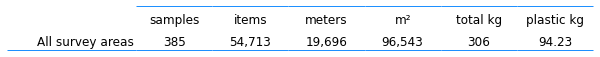

In [24]:
a_color='dodgerblue'

fig, axs = plt.subplots(figsize=(len(data.columns)*1.5,len(data)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.22, *[.13]*6], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

In [25]:
dims_summary_stats['plastic > 5mm weight'] = dims_summary_stats['plastic > 5mm weight'].round(2)
dims_summary_stats['total weight'] = dims_summary_stats['total weight'].round(3)
dims_summary_stats_display = dims_summary_stats.copy()
dims_summary_stats_display[ints] = dims_summary_stats_display[ints].applymap(lambda x: '{:,}'.format(int(x)))

data =dims_summary_stats_display[['# samples', 'pieces of trash',  'meters surveyed', 'm² surveyed', 'total weight', 'plastic > 5mm weight']].copy()
table_names = {"# samples":"samples", "pieces of trash":"items", "meters surveyed":"meters", "m² surveyed": "m²", "plastic > 5mm weight":"plastic kg", "total weight":"total kg"}
data.rename(columns=(table_names), inplace=True)
data.reset_index(inplace=True)

data['survey area'] = data['survey area'].map(lambda x: ut.use_this_key(x, comp_labels))

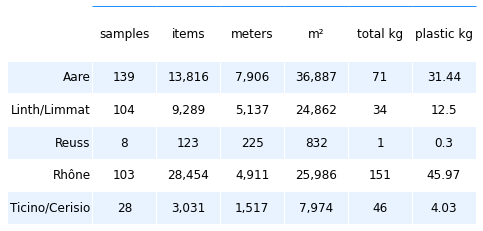

In [26]:
a_color='dodgerblue'

fig, axs = plt.subplots(figsize=(len(data.columns)*1.2,len(data)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.2, *[.15]*6], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color, s_et_bottom_row=False)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

In [27]:
new_dims = fd_dims[fd_dims.quantity != 'bad key'].copy()
new_dims = new_dims[new_dims.total_w > 0].copy()
new_dims['p/kg'] = new_dims.quantity/new_dims.total_w

**Table notes:** The totals are cumulative for each category. The total surface area surveyed was almost two hectares or twenty kilometers. The average of pieces of trash per kilogram was 1,049 and the median was 446. The weights were taken on location at the time of the survey, there was no attempt to dry the objects prior to taking the weight.

In [28]:
# print(new_dims['p/kg'].mean())
# print(np.quantile(new_dims['p/kg'].to_numpy(), [.25, .5, .75]))
# # print(len(new_dims['p/kg']))
# print(new_dims['p/kg'].min())
# print(new_dims['p/kg'].max())

# 1049.4056105952247
# [179.16666666666669 446.1077844311377 877.7777777777777]
# 1.0
# 39500.0

In [29]:
# material totals
fd_mat_totals = fd_mat_t.sort_values(by='quantity', ascending=False)

cols_to_use = {'material':'Material','quantity':'Quantity', '% of total':'% of total'}
fd_mat_totals['% of total'] =(fd_mat_totals['% of total']*100).round(1)
fd_mat_totals['quantity']=fd_mat_totals.quantity.map(lambda x: '{:,}'.format(x))
fd_mat_totals['% of total']=fd_mat_totals['% of total'].map(lambda x:F"{x}%")
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

#### Material type percent of total

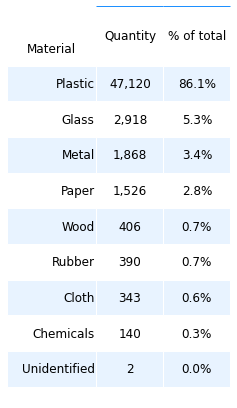

In [30]:
fig, ax = plt.subplots(figsize=(4,7))

ut.hide_spines_ticks_grids(ax)
ax.set_xlabel(" ")
a_table = ax.table(cellText=fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,fd_mat_totals,list(cols_to_use.values()), s_et_bottom_row=False)

plt.show()
plt.close()

**Material table notes** Cigarette ends are counted as plastic. Wood refers to treated wood or wood formed or fashioned for use. Chemicals refers to parafin wax.

[Menu](#top)<a id="stotal"></a>
### Survey totals pieces per 100 meters

In [31]:
sns.set_style('whitegrid')
# the monthly average
fd_dt['month'] = fd_dt.date.dt.month

fd_dindex = fd_dt.set_index('date')

monthly_plot = fd_dindex['p/100m'].resample('M').median()

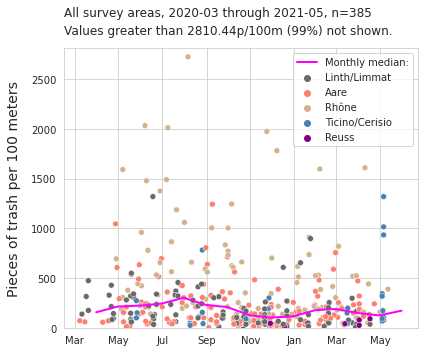

In [32]:
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)
fd_dt['survey area'] = fd_dt.river_bassin.map(lambda x: ut.use_this_key(x, comp_labels))
dist_all_surveys = ECDF(fd_dt['p/100m'].values)
 
bassin_pallette = {'rhone':'dimgray', 'aare':'salmon', 'linth':'tan', 'ticino':'steelblue', 'reuss':'purple'}
comp_palette = {"Linth/Limmat":"dimgray", "Rhône":"tan", "Aare":"salmon", "Ticino/Cerisio":"steelblue", "Reuss":"purple"}
fig, ax = plt.subplots(figsize=(6,5))

line_label = F"Monthly median:"

sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, color='magenta', label=line_label, linewidth=2, ax=ax)
sns.scatterplot(data=fd_dt, x='date', y='p/100m', hue='survey area', palette=comp_palette, s=34, ec='white', ax=ax)

the_90th = np.percentile(fd_dt["p/100m"], 99)
ax.set_ylim(0,the_90th )
not_included = F"Values greater than {round(the_90th, 2)}p/100m (99%) not shown."

ax.set_xlabel("")
ax.set_ylabel("Pieces of trash per 100 meters", **ck.xlab_k14)
ax.set_title(F"All survey areas, {start_date[:7]} through {end_date[:7]}, n={fd_n_samps}\n{not_included}",  **ck.title_k)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend( loc='upper right')

plt.tight_layout()
plt.show()
plt.close()

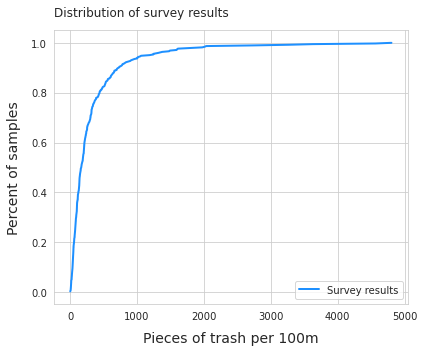

In [33]:
fig, ax = plt.subplots(figsize=(6,5))

sns.lineplot(x=dist_all_surveys.x, y=dist_all_surveys.y, color='dodgerblue', label="Survey results", linewidth=2, ax=ax)
ax.set_xlabel("Pieces of trash per 100m", **ck.xlab_k14)
ax.set_ylabel("Percent of samples", **ck.xlab_k14)
ax.set_title("Distribution of survey results", **ck.title_k )

plt.tight_layout()
plt.show()
plt.close()

In [34]:
change_names = {'count':'# samples', 'mean':'average p/100m', 'std':'standard deviation', 'min p/100m':'min', '25%':'25%',  '50%':'50%', '75%':'75%', 'max':'max p/100', 'min':'min p/100', 'total objects':'total objects', '# locations':'# locations', 'survey year':'survey year'}

def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

data = fd_dt

desc_2020 = data['p/100m'].describe().round(2)
desc_2020['total objects'] = data.quantity.sum()
desc_2020['# locations'] = fd.location.nunique()

desc_2020 = pd.Series(anew_dict(desc_2020))

combined_summary = desc_2020
not_formatted = combined_summary[-1]
combined_summary = [(x, "{:,}".format(int(combined_summary[x]))) for x in combined_summary.index[:-1]]
combined_summary.append((desc_2020.index[-1], int(not_formatted) ))

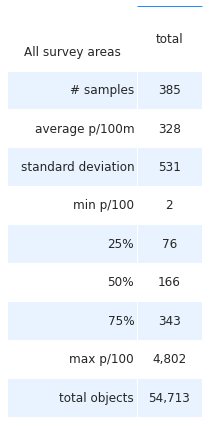

In [35]:
fig, ax = plt.subplots(figsize=(3,6))

a_col = ["All survey areas", 'total']

axone = ax
ut.hide_spines_ticks_grids(axone)
a_table = axone.table(cellText=combined_summary[:-1],  colLabels=a_col, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary[:-1],a_col, s_et_bottom_row=False)

plt.tight_layout()
plt.show()

#### Comparing results to previous studies Swiss Litter Report (2017 - 2018) - IQAASL:

**lakes and rivers**
Considering only the lakes and rivers that have samples in both years there were more samples and more trash was collected from fewer locations in 2017 than 2020. However, on a pieces per meter basis the mean, median and maximum were all higher in 2020. The difference is slight and in real terms is less than 30 pieces of trash per 100m, differences of this magnitude may not be immediately discernible to the casual observer1.

In both projects survey results are at their minimum in November through February(LOWS) and reach a maximum in April through July(HIGHS), seasonality of litter survey results has been noted noted previouslly.

**lakes**
The following lakes were sampled in both project years:

* Zurichsee
* Bielersee
* Neuenburgersee
* Walensee
* Lac Léman
* Thunersee

When just the six lakes are considered there were more samples, more locations and more trash was collected in 2020, but the median and average  survey result decreased by ~45% from 2017 to 2020. This is due in large part to the decrease in the number of cigarette ends, bottle caps, glass bottles and other products associated with consumption of food or tobacco.

> For the same period there was an increase in the median survey result for cotton swabs, plastic construction waste, industrial sheeting and other plastic and foam products.

For more information see the document *SLR - IQAASL*.

[Menu](#toc)<a id="themostcommonobjects"></a>
### Identifying the most common objects

In [36]:
# feature level top ten
rbt = code_totals.sort_values(by="quantity", ascending=False)[:10].copy()
rbt['item'] = rbt.index.map(lambda x: code_description_map.loc[x])
rbt['% of total'] = rbt["% of total"].map(lambda x: F"{x}%")

rb_t_ten_total = rbt.quantity.sum()
rb_t_ten_ptotal = rb_t_ten_total/code_totals.quantity.sum()

rbt['quantity'] = rbt.quantity.map(lambda x: '{:,}'.format(x))

cols_to_use = {'item':'Item','quantity':'Quantity', '% of total':'% of total'}
all_survey_areas = rbt[cols_to_use.keys()].values

l_all = code_totals[code_totals['fail rate'] >= 50].copy()
l_grtr_50 = l_all.index
l_all_list = [x for x in l_all.item.unique()]

# [x for x in l_grtr_50 if x not in rbt.index.values]
# rb_string = F"Combined, the ten most abundant objects represent {int(rb_t_ten_ptotal*100)}% of all objects found."
# md(rb_string)

In [37]:
most_common = list(set([*rbt.index.values, *l_grtr_50]))
fl_all_50 = fd[(fd.code.isin(most_common))].groupby('code').quantity.sum().sum()
combined_amount = round((fl_all_50/fd.quantity.sum())*100, 0)

a_string = F"""
The most common objects for the survey period are those objects that were either found in at least 50% of surveys or whose total object count is in the top-ten for the survey period.
Combined, these objects account for approximately {combined_amount}% of the trash found nationally.
"""
md(a_string)


The most common objects for the survey period are those objects that were either found in at least 50% of surveys or whose total object count is in the top-ten for the survey period.
Combined, these objects account for approximately 68.0% of the trash found nationally.


**The ten most abundant objects by quantity (top ten)**

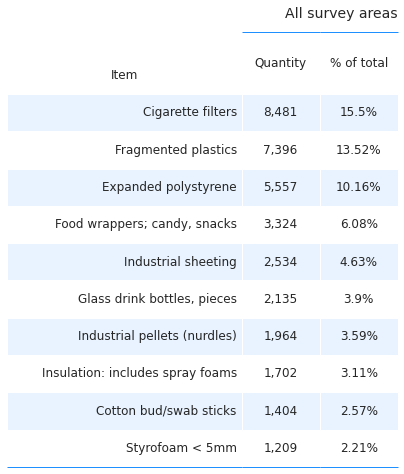

In [38]:
fig, axs = plt.subplots(figsize=(7,len(rbt)*.8))

ut.hide_spines_ticks_grids(axs)

axs.set_title(F"All survey areas", **ck.title_k14r)

the_first_table_data = axs.table(all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.6, .2,.2], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,rbt,list(cols_to_use.values()), a_color)

plt.show()
plt.tight_layout()
plt.close()

In [39]:

st_data =  fd[fd.code.isin(most_common)].copy()
s_data = st_data.groupby(['loc_date','river_bassin', 'code'], as_index=False)["p/100m"].sum()

data = s_data.groupby(['river_bassin', 'code'], as_index=False)["p/100m"].mean().pivot(index='code', columns='river_bassin', values="p/100m").sort_values(by='aare', ascending=False)
all_surveys_col = s_data.groupby('code')["p/100m"].mean()
data = pd.concat([data, all_surveys_col], axis=1)
data['item'] = data.index.map(lambda x: ut.use_this_key(x,code_description_map))
data.rename(columns={'p/100m':'All survey areas'}, inplace=True)
data.set_index('item', drop=True, inplace=True)
data = data.applymap(lambda x: round(x, 1))
data = data.astype('int')
data.rename(columns={x:comp_labels[x] for x in comp_labels.keys() },inplace=True)

There are twelve objects that meet the criteria, the top ten are listed in the table above. Plastic construction waste and metal bottle tops were found in at least 50% of the surveys.

#### The most common objects: average pieces per 100m

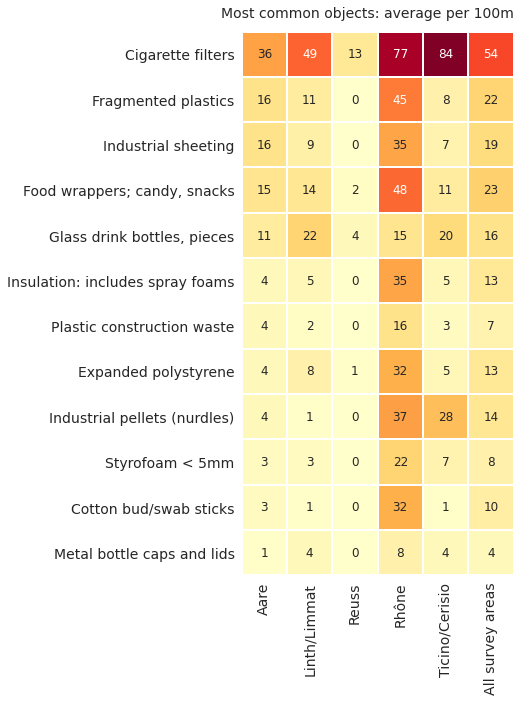

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

axone = ax

sns.heatmap(data, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12},  square=True, cbar=False, linewidth=.1, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both')
axone.set_title("Most common objects: average per 100m", **ck.title_k14r)

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

In [41]:
# a_mkdown_list = [F"{i+1}. {x}\n" for i,x in enumerate(l_all_list)]

# f = F"""
# **The following objects were found in at least 50% of all surveys nationally**\n\n

# {''.join(a_mkdown_list)}
# """
# md(f)

#### The most common objects monthly average

In [42]:
top_ten_month = fd[(fd.code.isin(most_common))].groupby(['loc_date', 'date', 'code'], as_index=False)['p/100m'].sum()
top_ten_month['month'] = top_ten_month.date.dt.month

dts_date = top_ten_month.copy()
dts_date.set_index('date', inplace=True)
group_names =  ['Gfoam','Gfrags','G117','G112','G67','G74', 'G89','G95','G30', 'G200', 'G27','G178']

mgr = {}

for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)]['p/100m'].resample('M').mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

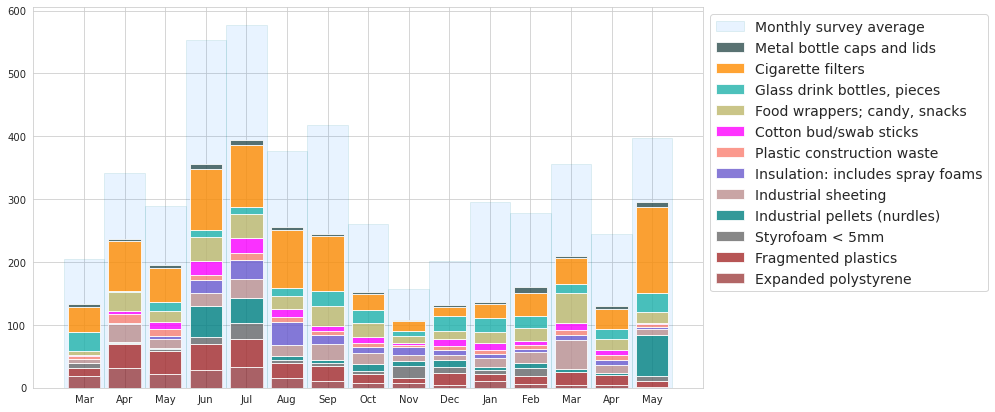

In [43]:
fig, ax = plt.subplots(figsize=(12,7))

colors_palette = {'G117':'dimgray', 'G112': 'teal',
    'G178': 'darkslategray',
    'G200': 'lightseagreen',
    'G27':'darkorange',
    'G30':'darkkhaki',
    'G67':'rosybrown',
    'G89': 'salmon',
    'G95':'magenta',
    'G74':'slateblue',
    'Gfoam': 'maroon',
    'Gfrags':'brown',
    'G208': 'turquoise',
    'G124':'indigo',
    'G25': 'chocolate',
    'G31': 'goldenrod',
    'G21': 'tan'    
}
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

bottom = [0]*len(mgr['G27'])

hmm = fd.groupby(['loc_date', 'date'], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})
hmm.set_index('date', inplace=True)
hmmx2017 = hmm['p/100m'].resample('M').mean().fillna(0)

this_x = [i for i,x in  enumerate(hmmx2017.index)]
ax.bar(this_x, hmmx2017.to_numpy(), color='dodgerblue', alpha=0.1, linewidth=1, edgecolor='teal', width=1, label="Monthly survey average") 


for i, a_group in enumerate(group_names):       
    
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    else:
        bottom += mgr[group_names[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)


new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monthly survey average")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("")
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

#### Change from highs to lows

In [44]:
mins20 = ["2020-11-30", "2021-02-28", "2020-12-31", "2021-01-31"]
maxs20 = ["2020-06-30", "2020-07-31", "2020-08-31", "2020-09-30"]

a_bucket = []
for element in group_names:
    data = mgr[element]
    decrease = (data.loc[maxs20].median() - data.loc[mins20].median())/data.loc[maxs20].median()
    a_bin = { "code":element, "max - min":decrease*-1}
    a_bucket.append(a_bin)
       
highs_to_lows = pd.DataFrame(a_bucket)
highs_to_lows['item'] = highs_to_lows.code.map(lambda x: ut.use_this_key(x, code_description_map))
h_l = highs_to_lows[['item', 'max - min']].set_index('item', drop=True)
h_l = h_l.apply(lambda x: (x*100).astype('int'))
h_l

,max - min
item,
Expanded polystyrene,-68
Fragmented plastics,-63
Styrofoam < 5mm,53
Industrial pellets (nurdles),-68
Industrial sheeting,-44
Insulation: includes spray foams,-72
Plastic construction waste,-22
Cotton bud/swab sticks,-49
"Food wrappers; candy, snacks",-56


In [45]:
st_data =  fd[fd.code.isin(most_common)].copy()
s_data = st_data[st_data.quantity > 0].groupby(['river_bassin', 'code'], as_index=False).loc_date.nunique()
fd_try_map = fd.groupby('river_bassin').loc_date.nunique()
s_data['tries'] = s_data.river_bassin.map(lambda x:fd_try_map.loc[x] )
s_data['fail rate'] = ((s_data.loc_date/s_data.tries)*100).astype('int')
data = s_data.pivot(values='fail rate', index='code', columns='river_bassin').fillna(0)

all_surveys_col = code_totals.loc[most_common]['fail rate']

data = pd.concat([data, all_surveys_col], axis=1)
data['item'] = data.index.map(lambda x: ut.use_this_key(x,code_description_map))
data.rename(columns={'fail rate':'All survey areas'}, inplace=True)
data.set_index('item', drop=True, inplace=True)
data.sort_values(by='All survey areas', ascending=False, inplace=True)


#### The most common objects: fail rate

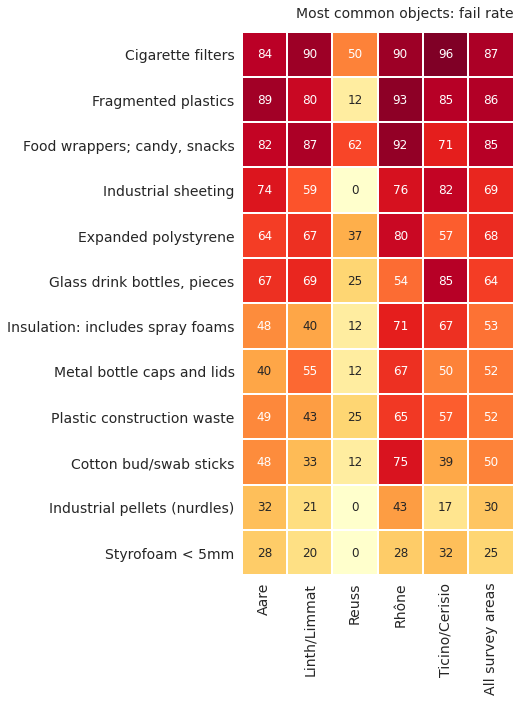

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
data.rename(columns={x:comp_labels[x] for x in comp_labels.keys() },inplace=True)

axone = ax

sns.heatmap(data, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt=".0f", square=True, cbar=False, linewidth=.1, linecolor='white')
axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both')
axone.set_title("Most common objects: fail rate", **ck.title_k14r)

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

#### Ranked correlation of survey results to land use attributes

This is a test to determine if there is a statistically significant relationship between land use and beach-litter-survey results.

The method used is the Spearman's rho or *Spearmans ranked correlation coefficient*<sup>11</sup>. The test results are evaluated at p<0.05 for all valid samples in the survey area<sup>12</sup>. 

1. Red/rose is a postitive correlation
2. Yellow is a negative correlation
3. White means that p>0.05, there is no statisitical basis to assume a correlation⁴.

A correlation is a relationship between the survey results and the land use attributes that is unlikely due to chance. The magnitude of the relationship is not defined and it is not linear. 

In [47]:
# the number of times an object was found at least once

corr_data = fd[(fd.code.isin(most_common))].copy()

inorder = code_totals.loc[most_common].sort_values(by='quantity', ascending=False).index
# corr_data.rename(columns={'str_rank':'street rank'}, inplace=True)
code_fails = corr_data.groupby('code').fail.sum()

# the ratio of found/not found
code_fail_rate = code_fails/fd.loc_date.nunique()

# all codes with a fail rate > fail rate
better_than_50 = code_fail_rate

some_keys = {
    '% to buildings':'lu_build',
    '% to agg':'lu_agg',
    '% to woods':'lu_woods',
    '% to recreation':'lu_rec',
    '% to trans':'lu_trans',
    '% to meadow':'lu_m',
    'str_rank':'lu_trans',}

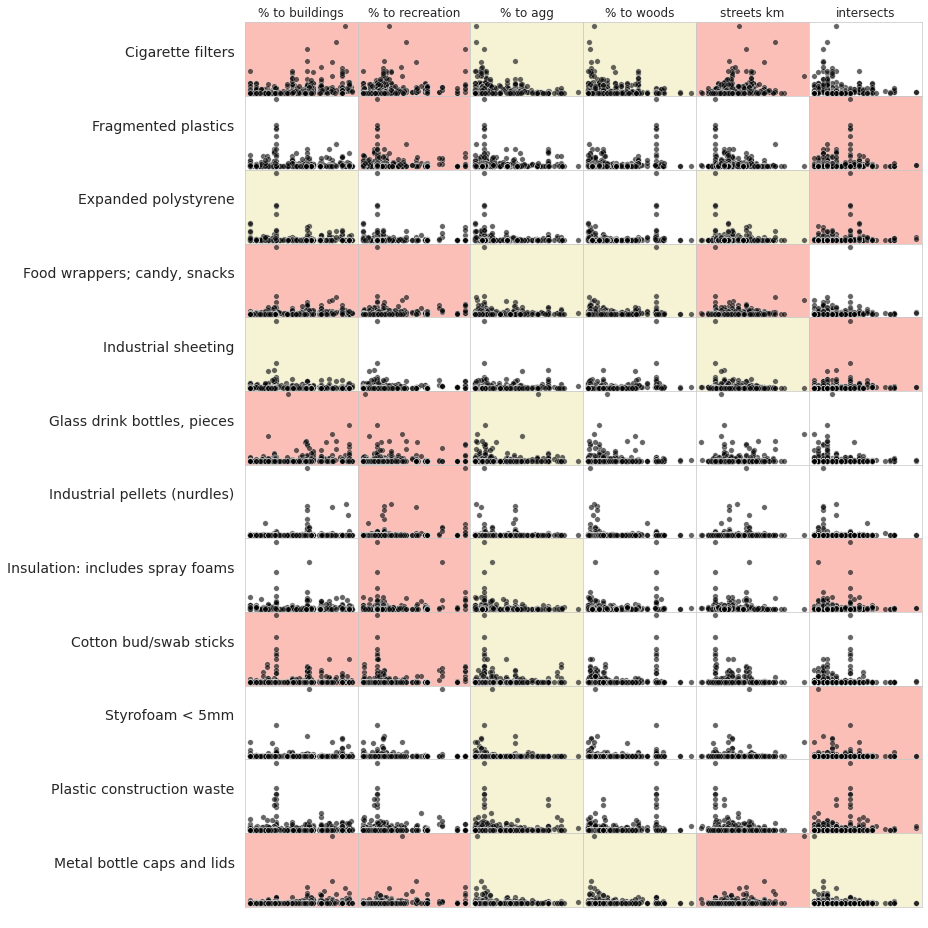

In [48]:
fig, axs = plt.subplots(len(most_common),len(luse_exp), figsize=(len(luse_exp)+7,len(most_common)+1), sharey='row')

for i,code in enumerate(inorder):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis='both', which='both',bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha='right', **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        _, corr, a_p = make_plot_with_spearmans(data, ax, n)
        
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor('salmon')
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor('palegoldenrod')
                ax.patch.set_alpha(0.5)
# plt.tick_params(labelsize=14, which='both', axis='both')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(F"{project_directory}/test_one.jpg", dpi=300)
plt.show()

**Interpreting results** 

The correlation results should allways be considered in conjuction with the number of samples. 

A positive correlation means that the land use attribute or feature had increased survey results when compared to other locations. This may be due to a covariance of attributes, either way **a positive correlation is a signal that the survey locations are near a zone of accumulation or a source**. This signal should be assessed along with the other key indicators at the responsible administrative level.

A negative correlation means that the land use feature or attribute does not facilitate the accumulation of the object. This result is common for aggricultural areas and woods on the national level. **A negative correlation is a signal that the locations are not a zone of accumulation for the object**.

No correlation means that the land use attribute or feature had no accumulating effect on the survey results for that object. The fail rate of the objects with none or few correlations should be consulted, especially when considering the most common objects:

1. Objects that have few correlations and a high fail rate are ubiquitous
2. Objects that have few correlations, low fail rate and high pcs/m maybe close to a source

[top](#top)
<a id='utility'></a>
### Utility of the objects found

The utility type is based on the utilisation of the object prior to it being discarded. Objects that are found are placed into to one of the 260 categories. Those categories are grouped according to utilisation.

For example, a piece of plastic could be placed into the category 'Fragmented plastics', depending on its size. However, a piece of plastic that was once a bucket
and we know this because we are familiar with either the brand or the product or if we recognize it as a piece of a bucket it is placed in the code for buckets<sup>13</sup>.

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastic items and pre-production plastic resins
*  **infrastructure**: items related to construction and maintenance of all infratructure items 
*  **food and drink**: primarily single use plastic items related to consuming food and drinks outdoors  
*  **agriculture**: primarily industrial sheeting includes mulch films
*  **tobacco**: primarily cigarette ends includes all smoking related material 
*  **recreation**: includes fishing, hunting, boating and beach related objects, excludes food, drink and tobacco items   
*  **packaging non food and drink**: packaging or wrapping material not identified as food, drink nor tobacco related  
*  **plastic fragments**: foam and plastic fragments of indeterminate origin and use 
*  **personal items**: accessories, hygiene and clothing related 

<sup>13</sup> See the annex for the complete list of objects identified, includes category and group classification - the code for a buckets is G57

#### Utility as a % of the total objects found

In [49]:
s_data = fd.groupby(['river_bassin', 'groupname'], as_index=False).quantity.sum()
s_data["d_t"] = s_data.river_bassin.map(lambda x: s_data.groupby('river_bassin').quantity.sum()[x])
s_data["p_t"] = s_data.quantity/s_data.d_t
data = s_data.pivot(index='groupname', values='p_t', columns='river_bassin')

all_surveys_col = fd.groupby(['groupname']).quantity.sum()/fd.quantity.sum()
data = pd.concat([data, all_surveys_col], axis=1)
data.rename(columns={'quantity':'All survey areas'}, inplace=True)

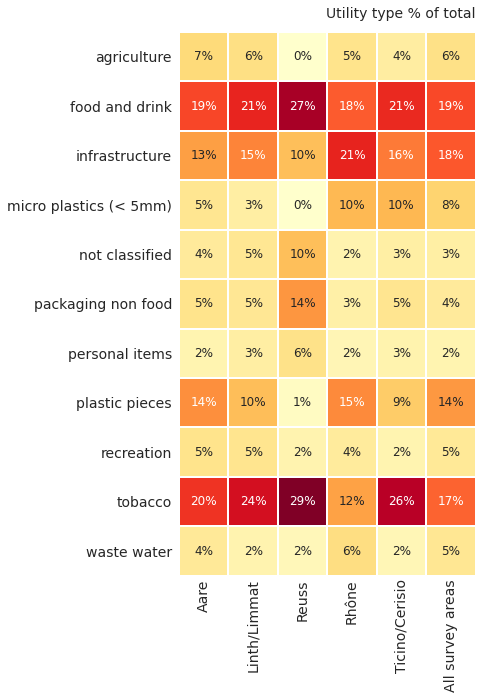

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
data.rename(columns={x:comp_labels[x] for x in comp_labels.keys() },inplace=True)
axone = ax
sns.heatmap(data, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, cbar=False, linewidth=.1, fmt='.0%', square=True, linecolor='white')
axone.set_title("Utility type % of total", **ck.title_k14r)
axone.tick_params(**ck.no_xticks)
axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both')

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)
plt.show()

In [51]:
top_ten_month = fd.groupby(['loc_date', 'date', 'groupname'], as_index=False)['p/100m'].sum()
top_ten_month['month'] = top_ten_month.date.dt.month

dts_date = top_ten_month.copy()
dts_date.set_index('date', inplace=True)
groupnames = ['infrastructure','agriculture','plastic pieces', 'waste water', 'micro plastics (< 5mm)', 'not classified','packaging non food', 'personal items', 'recreation', 'food and drink','tobacco' ]

mgr = {}

for a_group in groupnames:
    a_plot = dts_date[(dts_date.groupname==a_group)]['p/100m'].resample('M').mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

#### Monthly average p/100m utility: 

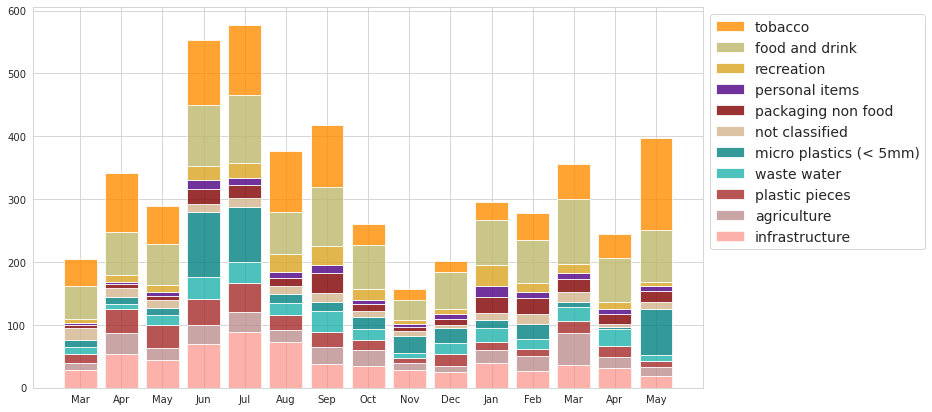

In [52]:
fig, ax = plt.subplots(figsize=(12,7))
colors_palette2 = {'G117':'dimgray', 'micro plastics (< 5mm)': 'teal',
    'G178': 'darkslategray',
    'waste water': 'lightseagreen',
    'tobacco':'darkorange',
    'food and drink':'darkkhaki',
    'agriculture':'rosybrown',
    'infrastructure': 'salmon',
    'G95':'magenta',
    'G74':'green',
    'packaging non food': 'maroon',
    'plastic pieces':'brown',
    'G208': 'turquoise',
    'personal items':'indigo',
    'G25': 'chocolate',
    'recreation': 'goldenrod',
    'not classified': 'tan'    
}

bottom = [0]*len(mgr['waste water'])

this_x = [i for i,x in  enumerate(hmmx2017.index)]

for i, a_group in enumerate(groupnames):       
    
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette2[a_group], linewidth=1, alpha=0.6 ) 
    else:
        bottom += mgr[groupnames[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette2[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()

plt.xticks(ticks=axisticks, labels=labelsx)
new_labels = [x for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monthly survey average")
ax.set_title("")
    
plt.legend(handles=handles[::-1], labels=labels[::-1], bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

#### Change from HIGHS to LOWS:

In [53]:
mins20 = ["2020-11-30", "2021-02-28", "2020-12-31", "2021-01-31"]
maxs20 = ["2020-06-30", "2020-07-31", "2020-08-31", "2020-09-30"]

a_bucket = []
for element in groupnames:
    data = mgr[element]
    decrease = (data.loc[maxs20].median() - data.loc[mins20].median())/data.loc[maxs20].median()
    a_bin = { "code":element, "max - min":decrease*-1}
    a_bucket.append(a_bin)
       
highs_to_lows = pd.DataFrame(a_bucket)
h_l = highs_to_lows.set_index('code')
h_l = h_l.apply(lambda x: (x*100).astype('int'))
h_l

,max - min
code,
infrastructure,-61
agriculture,-41
plastic pieces,-63
waste water,-50
micro plastics (< 5mm),-53
not classified,-22
packaging non food,-23
personal items,-34
recreation,-54


<br></br>
### More information

Contact hammerdirt.ch for any questions about the content of this report. If you would like a report for your municipality contact the Swiss federal office for the environment: Municipal waste section.

In [54]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")

### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-07-08.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>


[top](#top)<a id="annex"></a>
### Annex

1. [surveyors](#us)
2. [Survey location GPS](#gps)
3. [Inventory of all objects removed](#inventory)

#### Effective data

The data is submitted in two parts. If a survey is missing either part we check the paper records and update when possible. There are three survey records missing dimensional data for the survey period:

In [55]:
print(', '.join([str(x) for x in no_matching_dim_records]))

('baby-plage-geneva', '2021-04-14'), ('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31')


The average length and survey area for each location was used to replace the missing values for each record.

[annex](#annex)<a id="us"></a>
#### IQAASL surveyors

Hammerdirt staff:

1. Shannon Erismann, field operations manager
2. Helen Kurukulasuriya, surveyor
3. Débora Carmo, surveyor
4. Bettina Siegenthaler, surveyor
5. Roger Erismann, surveyor

Participating organizations:

1. Precious plastic leman
2. Association pour la sauvetage du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédéral Lausanne

[Annex](#annex)<a id='gps'></a>

#### Survey locations

In [56]:
# display the survey locations
disp_columns = ['location', 'latitude', 'longitude', 'water_name', 'city']
disp_beaches = dfBeaches.loc[fd_locs][disp_columns]
disp_beaches

,location,latitude,longitude,water_name,city
slug,,,,,
maladaire,Maladaire,46.446296,6.876960,Lac Léman,La Tour-de-Peilz
preverenges,Préverenges,46.512690,6.527657,Lac Léman,Préverenges
caprino,caprino,45.987963,8.986241,Lago di Lugano,Lugano
foce-del-cassarate,Foce del Cassarate,46.002411,8.961477,Cassarate,Lugano
lido,Lido,46.002004,8.962156,Lago di Lugano,Lugano
...,...,...,...,...,...
tolochenaz,Tolochenaz,46.497509,6.482875,Lac Léman,Tolochenaz
limmat_zuerich_suterdglauserp,limmat_zuerich_suterd&glauserp,47.394539,8.513443,Limmat,Zürich
aare_post,Aare_post,47.116665,7.271953,Aare|Nidau-Büren-Kanal,Port


[Annex](#annex)<a id="inventory" ></a>
#### Inventory of all items

In [57]:

# complete_inventory = code_totals[['item', 'quantity', 'utility',  '% of total','% of samples']]

In [58]:
pd.set_option('display.max_rows', None)
# complete_inventory[complete_inventory.quantity > 0].sort_values(by='quantity', ascending=False)